In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import folium
from haversine import haversine, Unit
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
%matplotlib inline

# 관련 라이브러리 임포트 
import matplotlib.font_manager as fm

#  한글글꼴로 변경
# plt.rcParams['font.family'] = '한글글꼴명'
plt.rcParams['font.size'] = 22.0
# plt.rcParams['font.family'] = 'batang'
plt.rcParams['font.family'] = 'Malgun Gothic'

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
matplotlib.rcParams['axes.unicode_minus'] = False

# 그래프 기본 크기 설정 
plt.rcParams['figure.figsize'] = [20, 6]

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('data/database.xlsx')
df.head()

,ID,거래금액(만원)_18/1,전세금(만원)_18/1,등락율18/1,전세가율18/1,인접역 수,전용면적,건축년도,Brand,BrandPower,...,인접역 수.17,전용면적.17,건축년도.17,Brand.17,BrandPower.17,구별인구.17,거래량18,cluster18,위도,경도
0,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,129125.0,42166.7,4.162633,32.7,0,80,1987.0,0,0,...,0,80,1987.0,0,0,536710,3,4,37.483372,127.053437
1,서울특별시 강남구 개포동 개포주공1단지 40,145736.8,10166.7,16.507998,7.0,1,40,1982.0,0,0,...,1,40,1982.0,0,0,536710,0,4,37.483381,127.057068
2,서울특별시 강남구 개포동 개포주공5단지 60,136666.7,42678.6,0.000000,31.2,1,60,1983.0,0,0,...,1,60,1983.0,0,0,536710,0,4,37.487868,127.068988
3,서울특별시 강남구 개포동 개포주공5단지 80,177416.7,45000.0,0.000000,25.4,1,80,1983.0,0,0,...,1,80,1983.0,0,0,536710,0,4,37.487868,127.068988
4,서울특별시 강남구 개포동 개포주공6단지 50,125900.0,37909.1,9.134234,30.1,1,50,1983.0,0,0,...,1,50,1983.0,0,0,536710,0,4,37.488481,127.072502


In [3]:
df.iloc[:,24]

0       4
1       4
2       4
3       4
4       4
       ..
4086    0
4087    0
4088    0
4089    0
4090    0
Name: cluster2, Length: 4091, dtype: int64

In [4]:
dic = {}
num = 12

for i1 in range(1,19):
    dic[f'data{i1}'] = df.iloc[:,num]
    num += 12

dic['data1']

0       4
1       4
2       4
3       4
4       4
       ..
4086    2
4087    0
4088    0
4089    0
4090    0
Name: cluster1, Length: 4091, dtype: int64

In [5]:
cluster = pd.concat([dic['data1'],dic['data2'],dic['data3'],dic['data4'],dic['data5'],dic['data6'],dic['data7'],dic['data8'],dic['data9'],dic['data10'],dic['data11'],dic['data12'],dic['data13'],dic['data14'],dic['data15'],dic['data16'],dic['data17'],dic['data18']], axis=1)
cluster

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18
0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,2
4087,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4088,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4089,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


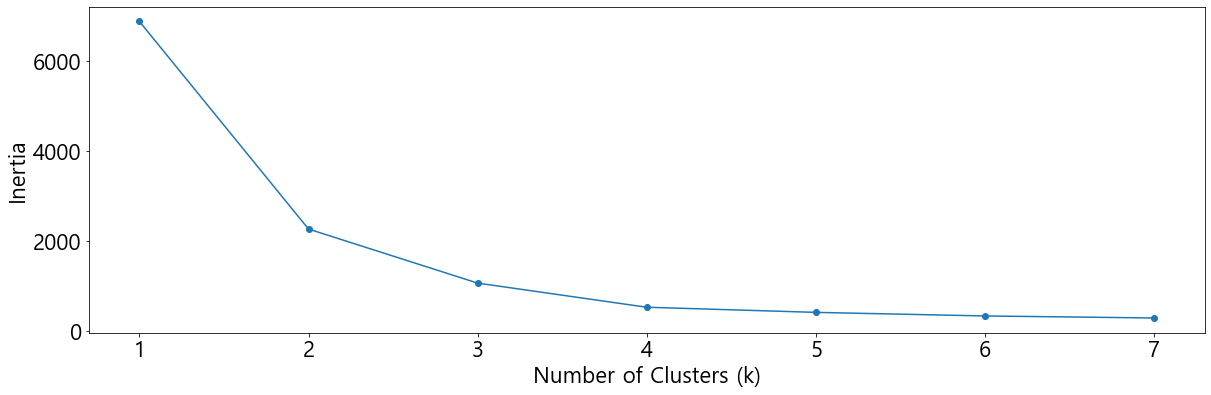

In [6]:
mm = MinMaxScaler()
mm_scaled = mm.fit_transform(cluster)
samples = pd.DataFrame(mm_scaled)

# 최적의 k값 찾기-배껴온 코드
num_clusters = list(range(1, 8))	# K는 1 ~ 8사이의 정수입니다
inertias = []
# 각 K별로 모델을 생성하여 inertia를 측정합니다
for i in num_clusters:
    model = KMeans(n_clusters=i)
    model.fit(samples)
    inertias.append(model.inertia_)
# K에 따른 inertia의 변화를 시각화합니다
plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [7]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=np.random.RandomState(seed=1))

clusters1 = kmeans.fit(samples)
clusters1.labels_

array([1, 1, 1, ..., 3, 3, 3])

In [11]:
ddf = pd.DataFrame(clusters1.labels_)

In [13]:
ddff = pd.concat([df['ID'],ddf], axis=1)
ddff

,ID,0
0,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,1
1,서울특별시 강남구 개포동 개포주공1단지 40,1
2,서울특별시 강남구 개포동 개포주공5단지 60,1
3,서울특별시 강남구 개포동 개포주공5단지 80,1
4,서울특별시 강남구 개포동 개포주공6단지 50,1
...,...,...
4086,서울특별시 중랑구 중화동 중화동건영아파트 60,3
4087,서울특별시 중랑구 중화동 태능에셈빌 80,3
4088,서울특별시 중랑구 중화동 한신아파트 50,3
4089,서울특별시 중랑구 중화동 한신아파트 60,3
